# 0. Library Import 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# 1. Data Aggregation and Time-series Clustering

In [2]:
# Create a folder to save all the project result
os.makedirs('Project 1', exist_ok=True)

In [3]:
# Time series import
excel = pd.ExcelFile('Dutch retail chain sales dataset.xlsx')
excel_sheets = excel.sheet_names
excel_frames = {excel_sheet: pd.read_excel(excel, sheet_name=excel_sheet) for excel_sheet in excel_sheets}
append_df = pd.concat([excel_frames[excel_sheet] for excel_sheet in excel_sheets[1:]], ignore_index=True)
append_df['salesdate'] = pd.to_datetime(append_df['salesdate'], format='%Y%m%d')

In [4]:
# Check the data quality
print(append_df.info())
print('\nThe number of missing value:')
print(append_df.isnull().sum())
print('\nThe number of duplicated value:',append_df.duplicated().sum())
print('\nThe negative value of demand:',(append_df['demand']<0).sum())
print(append_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269374 entries, 0 to 3269373
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   SKU        int64         
 1   salesdate  datetime64[ns]
 2   demand     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 74.8 MB
None

The number of missing value:
SKU          0
salesdate    0
demand       0
dtype: int64

The number of duplicated value: 0

The negative value of demand: 16017
                SKU                      salesdate        demand
count  3.269374e+06                        3269374  3.269374e+06
mean   4.181781e+03  2020-09-29 04:35:42.874812928  8.300791e+01
min    1.111000e+03            2018-04-01 00:00:00 -1.101000e+03
25%    2.649000e+03            2020-02-19 00:00:00  9.000000e+00
50%    4.210000e+03            2020-12-13 00:00:00  2.500000e+01
75%    5.700000e+03            2021-06-18 00:00:00  7.400000e+01
max    7.246000e+03            2021-12-14 00:00:00  8.1

<div class="alert alert-block alert-info">
<b>Conclusion:
</b><br>- The time series dataset is in a good quality with no missing and duplicated values.
<br>- However, there are negative demand values, which will be processed in the next step.
</div>

In [5]:
#Transform negative demand to zero and group the sum of demand by month and SKU
append_df.loc[append_df['demand'] < 0, 'demand'] = 0
monthly_df = append_df.groupby([pd.Grouper(key='salesdate',freq='MS'), 'SKU'])['demand'].sum().reset_index()
monthly_df.set_index('salesdate', inplace=True)

In [6]:
# Select all valid SKUs with sufficient 45 data points and transform to a pivot table
valid_skus = monthly_df[monthly_df['demand'] > 0].groupby('SKU').filter(lambda x: len(x) >= monthly_df.index.nunique())
valid_skus_pivot = valid_skus.pivot_table(index='salesdate', columns='SKU', values='demand')

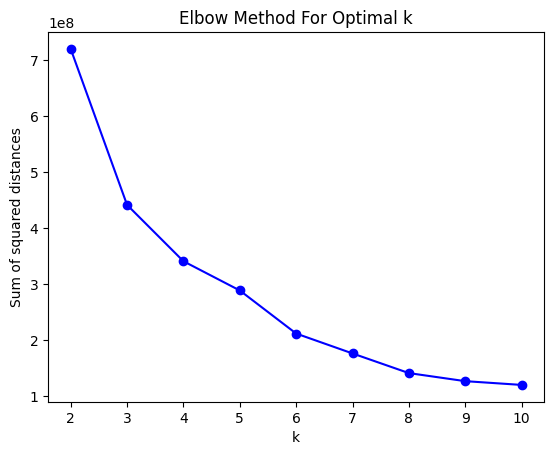

In [7]:
# Select the optimal number of cluster for all valid SKUs time series using DTW metric and plot the result
valid_skus_matrix = valid_skus_pivot.T.values

sum_of_squared_distances = []
K = range(2,11)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=100)
    
    km = km.fit(valid_skus_matrix)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<div class="alert alert-block alert-info">
<b>Conclusion:
</b><br>- From the plot, it is a bit unclear to the potential candidates for the optimal number of clusters.
<br>- However, from my own preference, the kink of the plot is at '6'. Therefore, I will cluster all the valid time series into 6 clusters.

In [8]:
# Cluster using KMeans with DTW metric and find the medoid SKU for each cluster
scaler = TimeSeriesScalerMeanVariance()
scaled_skus = scaler.fit_transform(valid_skus_matrix)

kmeans = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=50, random_state=100, n_jobs=-1)
kmeans.fit(scaled_skus)

cluster_labels = kmeans.labels_

sku_names = valid_skus_pivot.columns.values
medoid_skus = []
for cluster in range(kmeans.n_clusters):
    # Indices of SKUs in this cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    # Subset of time series in this cluster
    cluster_series = scaled_skus[cluster_indices]
    # Compute pairwise DTW distances within the cluster
    dists = cdist_dtw(cluster_series)
    # Find the medoid (min sum of distances)
    medoid_idx = cluster_indices[np.argmin(dists.sum(axis=0))]
    medoid_skus.append(sku_names[medoid_idx])

# 2. Exploratory Data Analyst

In [9]:
# Create a folder to save EDA result
os.makedirs('Project 1/1. Data exploration', exist_ok=True)

In [10]:
# Plot the original value of medoid SKUs with their cluster
for i, medoid in enumerate(medoid_skus):
    sku_demand = valid_skus[valid_skus['SKU'] == medoid]['demand'].asfreq('MS')
    plt.figure(figsize=(14,6))
    plt.plot(sku_demand.index, sku_demand)
    plt.title(f'Demand for SKU {medoid} in Cluster {i}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.savefig(f'Project 1/1. Data exploration/Line plot of Cluster {i} + SKU {medoid}.png')
    plt.close()

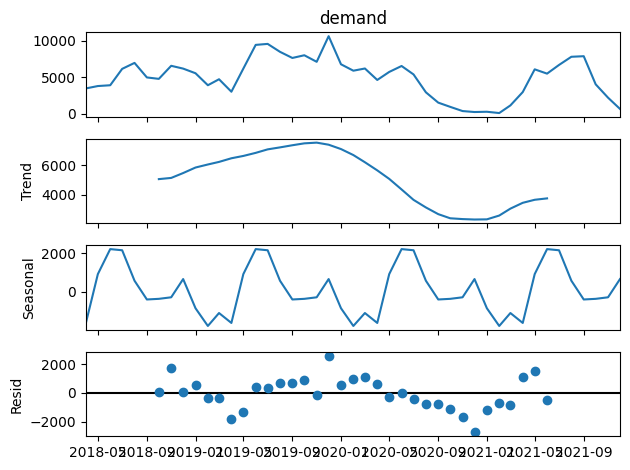

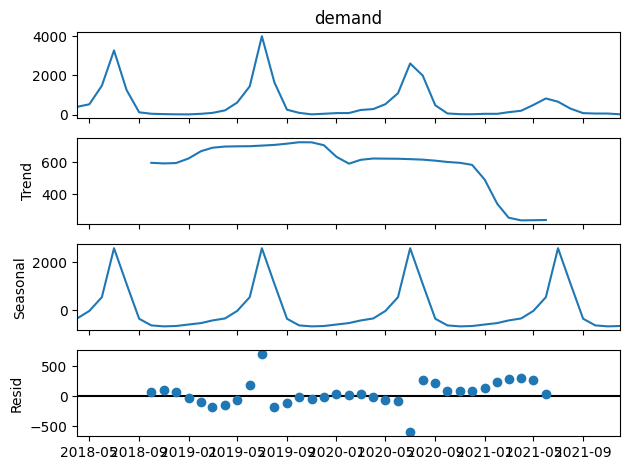

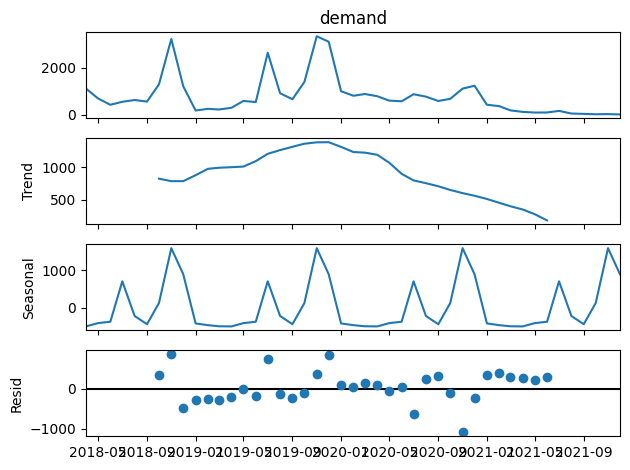

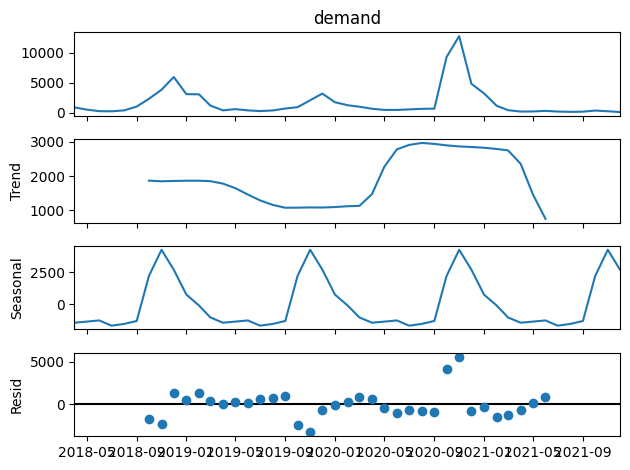

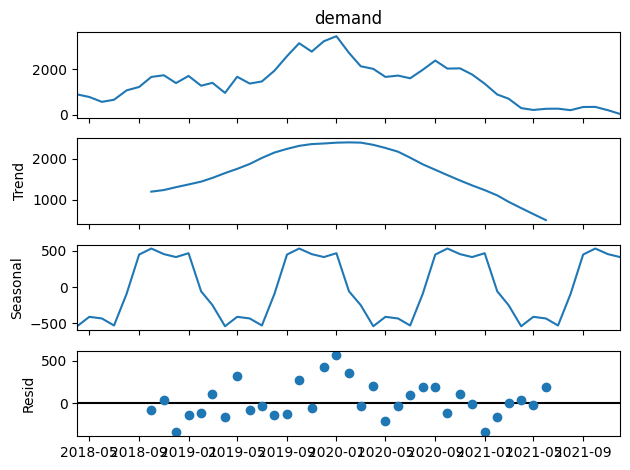

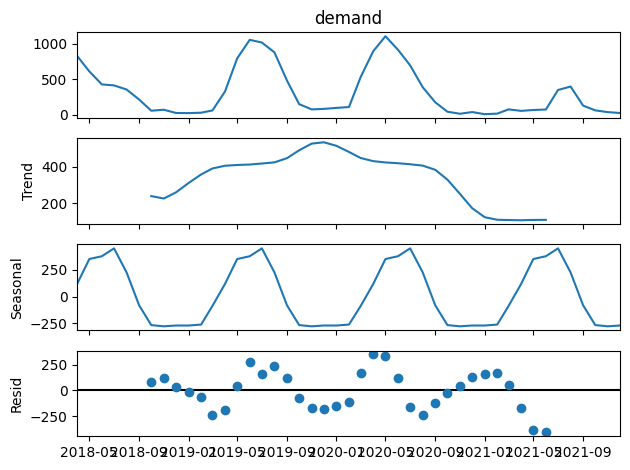

In [11]:
# Plot the seasonal decomposition of medoid SKUs with their cluster
for i, medoid in enumerate(medoid_skus):
    sku_demand = valid_skus[valid_skus['SKU'] == medoid]['demand'].asfreq('MS')
    decomposition = seasonal_decompose(sku_demand, model = 'additive', period = 12)
    decomposition.plot()
    decomposition.plot().set_size_inches((14, 8))
    plt.suptitle(f'Seasonal Decomposition of SKU {medoid} in cluster {i}')
    plt.savefig(f'Project 1/1. Data exploration/Decomposition plot of Cluster {i} + SKU {medoid}.png')
    plt.close()

<div class="alert alert-block alert-info">
<b>Conclusion:
</b><br>- From the decomposition plots, SKU 1596, 3260, 4271, 6206 have a <b>strong </b>seasonal pattern, which is a suggestion for forecasting models with seasonal components.
<br>- On the other hand, SKU 1563 and 3086 do not express clear seasonality.

In [12]:
# Plot the ACF and PACF of the SKUs with their cluster
for i, medoid in enumerate(medoid_skus):
    sku_demand = valid_skus[valid_skus['SKU'] == medoid]['demand'].asfreq('MS')
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    plot_acf(sku_demand, lags=12, ax=axes[0], zero=False, title=f'ACF of SKU {medoid} in Cluster {i}')
    plot_pacf(sku_demand, lags=12, ax=axes[1], zero=False, title=f'PACF of SKU {medoid} in Cluster {i}')
    plt.savefig(f'Project 1/1. Data exploration/ACF and PACF plot of Cluster {i} + SKU {medoid}.png')
    plt.close()

<div class="alert alert-block alert-info">
<b>Conclusion:
</b><br>- No SKUs had statistically significant autocorrelation lags exceeding 3, and partial autocorrelation lags exceeding 2. Except for SKU 1596, which had both autocorrelation and partial autocorrelation metrics with a statistical significance lag of 12.
<br>- This will be the basis for selecting parameters for the (S)ARIMA(X) model and feature engineering for the XGBoost model.

# 3. Model Training and Evaluation

## 3.1. Exponential Smoothing (ETS)

In [13]:
# Create a folder to save ETS result
os.makedirs('Project 1/2. ETS model', exist_ok=True)

In [14]:
# Fit ETS(A,A,A) models for each medoid SKU using expanding window cross-validation
# Start expanding window at 36 months, use 1-step-ahead forecasts for validation and MSE and MAPE for evaluation
ets_results = []
train_size = 36

for i, medoid in enumerate(medoid_skus):
    sku_series = valid_skus_pivot[medoid].asfreq('MS')
    n = len(sku_series)
    mse_list = []
    mape_list = []
    forecast_values = []

    for end in range(train_size, n):
        train, test = sku_series[:end], sku_series[end:end+1]
        model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
        fit_model = model.fit(optimized=True)
        forecast = fit_model.forecast(1)
        mse = (forecast - test) ** 2
        mape = abs((forecast - test)/test) * 100
        forecast_values.append(forecast)
        mse_list.append(mse)
        mape_list.append(mape)

    avg_mse = float(np.nanmean(mse_list))
    avg_mape = float(np.nanmean(mape_list))

    ets_results.append({
        'SKU': medoid,
        'Cluster': i,
        'Model': 'ETS(A,A,A)',
        'MSE': avg_mse,
        'MAPE': avg_mape
    })
    
    plt.figure(figsize=(14, 6))
    plt.plot(sku_series.index, sku_series, label='Actual', marker='o', linestyle='-', linewidth=2)
    plt.plot(sku_series.index[train_size:], forecast_values, label='1-step-ahead Forecast', 
             marker='s', linestyle='--', linewidth=2, alpha=0.75, color='red')
    plt.axvline(x=sku_series.index[train_size], color='gray', linestyle=':', alpha=0.5, label='Validation Start')
    plt.title(f'ETS(A,A,A) Expanding-Window Validation for SKU {medoid} in cluster {i}\nAvg MSE: {avg_mse:.2f}, Avg MAPE: {avg_mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('Project 1/2. ETS model', f'ETS model of Cluster {i} + SKU {medoid}.png')
    plt.savefig(plot_path)
    plt.close()

ets_results_df = pd.DataFrame(ets_results)
ets_results_df.to_csv('Project 1/2. ETS model/ETS results.csv', index=False)

## 3.2. AutoRegressive Integrated Moving Average (ARIMA)

In [15]:
# Create a folder to save ARIMA result
os.makedirs('Project 1/3. ARIMA model', exist_ok=True)

In [16]:
# Fit ARIMA models for each medoid SKU using expanding window cross-validation
# Use auto_arima to find best (p,d,q) parameters for each training window
# Start expanding window at 36 months, use 1-step-ahead forecasts for validation and MSE and MAPE for evaluation
arima_results = []

for i, medoid in enumerate(medoid_skus):
    sku_series = valid_skus_pivot[medoid].asfreq('MS')
    n = len(sku_series)
    mse_list = []
    mape_list = []
    forecast_values = []
    best_orders = []

    for end in range(train_size, n):
        train, test = sku_series[:end], sku_series[end:end+1]
        auto_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5,
                                seasonal=False,
                                stepwise=True, trace=False, error_action='ignore', 
                                suppress_warnings=True, maxiter=200)
        forecast = auto_model.predict(n_periods=1)
        mse = (forecast - test) ** 2
        mape = abs((forecast - test)/test) * 100
        mse_list.append(mse)
        mape_list.append(mape)
        forecast_values.append(forecast)
        best_orders.append(auto_model.order)

    avg_mse = float(np.nanmean(mse_list))
    avg_mape = float(np.nanmean(mape_list))
    
    order_counter = Counter(best_orders)
    most_common_order = order_counter.most_common(1)[0][0]

    arima_results.append({
        'SKU': medoid,
        'Cluster': i,
        'Model': f'ARIMA{most_common_order}',
        'MSE': avg_mse,
        'MAPE': avg_mape
    })
    
    plt.figure(figsize=(14, 6))
    plt.plot(sku_series.index, sku_series, label='Actual', marker='o', linestyle='-', linewidth=2)
    plt.plot(sku_series.index[train_size:], forecast_values, label='1-step-ahead Forecast', 
             marker='s', linestyle='--', linewidth=2, alpha=0.75, color='red')
    plt.axvline(x=sku_series.index[train_size], color='gray', linestyle=':', alpha=0.5, label='Validation Start')
    plt.title(f'ARIMA{most_common_order} Expanding-Window Validation for SKU {medoid} (Cluster {i})\nAvg MSE: {avg_mse:.2f}, Avg MAPE: {avg_mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('Project 1/3. ARIMA model', f'ARIMA model of Cluster {i} + SKU {medoid}.png')
    plt.savefig(plot_path)
    plt.close()

arima_results_df = pd.DataFrame(arima_results)
arima_results_df.to_csv('Project 1/3. ARIMA model/ARIMA results.csv', index=False)

## 3.3. Seasonal AutoRegressive Integrated Moving Average (SARIMA)

In [17]:
# Create a folder to save SARIMA result
os.makedirs('Project 1/4. SARIMA model', exist_ok=True)

In [18]:
# Fit SARIMA models for each medoid SKU using expanding window cross-validation
# Use auto_arima to find best (p,d,q,P,D,Q) parameters for each training window
# Start expanding window at 36 months, use 1-step-ahead forecasts for validation and MSE and MAPE for evaluation
sarima_results = []

for i, medoid in enumerate(medoid_skus):
    sku_series = valid_skus_pivot[medoid].asfreq('MS')
    n = len(sku_series)
    mse_list = []
    mape_list = []
    forecast_values = []
    best_orders = []

    for end in range(train_size, n):
        train, test = sku_series[:end], sku_series[end:end+1]
        auto_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5,
                                seasonal=True, start_P=0, start_Q=0, max_P=3, max_Q=3, m=12,
                                stepwise=True, trace=False, error_action='ignore', 
                                suppress_warnings=True, maxiter=200)
        forecast = auto_model.predict(n_periods=1)
        mse = (forecast - test) ** 2
        mape = abs((forecast - test)/test) * 100
        mse_list.append(mse)
        mape_list.append(mape)
        forecast_values.append(forecast)
        best_orders.append((auto_model.order, getattr(auto_model, 'seasonal_order', None)))

    avg_mse = float(np.nanmean(mse_list))
    avg_mape = float(np.nanmean(mape_list))
    
    order_counter = Counter(best_orders)
    most_common_order = order_counter.most_common(1)[0][0]

    sarima_results.append({
        'SKU': medoid,
        'Cluster': i,
        'Model': f'SARIMA{most_common_order}',
        'MSE': avg_mse,
        'MAPE': avg_mape
    })
    
    plt.figure(figsize=(14, 6))
    plt.plot(sku_series.index, sku_series, label='Actual', marker='o', linestyle='-', linewidth=2)
    plt.plot(sku_series.index[train_size:], forecast_values, label='1-step-ahead Forecast', 
             marker='s', linestyle='--', linewidth=2, alpha=0.75, color='red')
    plt.axvline(x=sku_series.index[train_size], color='gray', linestyle=':', alpha=0.5, label='Validation Start')
    plt.title(f'SARIMA{most_common_order} Expanding-Window Validation for SKU {medoid} (Cluster {i})\nAvg MSE: {avg_mse:.2f}, Avg MAPE: {avg_mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('Project 1/4. SARIMA model', f'SARIMA model of Cluster {i} + SKU {medoid}.png')
    plt.savefig(plot_path)
    plt.close()

sarima_results_df = pd.DataFrame(sarima_results)
sarima_results_df.to_csv('Project 1/4. SARIMA model/SARIMA results.csv', index=False)

## 3.4. AutoRegressive Integrated Moving Average with eXogenous inputs (ARIMAX)

In [19]:
# Exogenous inputs import
exog_df = pd.read_excel("Exogenous variables.xlsx", index_col='Periods', parse_dates=True)
merge_exog = pd.merge(valid_skus_pivot, exog_df, left_index=True, right_index=True)
merge_exog.asfreq('MS')
exog_var = exog_df.columns

In [20]:
# Create a folder to save ARIMAX result
os.makedirs('Project 1/5. ARIMAX model', exist_ok=True)

In [21]:
# Fit ARIMAX models for each medoid SKU using expanding window cross-validation
# Use auto_arima to find best (p,d,q) parameters for each training window
# Start expanding window at 36 months, use 1-step-ahead forecasts for validation and MSE and MAPE for evaluation
arimax_results = []

for i, medoid in enumerate(medoid_skus):
    sku_series = valid_skus_pivot[medoid].asfreq('MS')
    n = len(sku_series)
    mse_list = []
    mape_list = []
    forecast_values = []
    best_orders = []

    for end in range(train_size, n):
        train, test = sku_series[:end], sku_series[end:end+1]
        exog_train, exog_test = merge_exog[exog_var][:end], merge_exog[exog_var][end:end+1]
        auto_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5,
                                seasonal=False, X = exog_train,
                                stepwise=True, trace=False, error_action='ignore', 
                                suppress_warnings=True, maxiter=200)
        forecast = auto_model.predict(n_periods=1, X = exog_test)
        mse = (forecast - test) ** 2
        mape = abs((forecast - test)/test) * 100
        mse_list.append(mse)
        mape_list.append(mape)
        forecast_values.append(forecast)
        best_orders.append(auto_model.order)

    avg_mse = float(np.nanmean(mse_list))
    avg_mape = float(np.nanmean(mape_list))
    
    order_counter = Counter(best_orders)
    most_common_order = order_counter.most_common(1)[0][0]

    arimax_results.append({
        'SKU': medoid,
        'Cluster': i,
        'Model': f'ARIMAX{most_common_order}',
        'MSE': avg_mse,
        'MAPE': avg_mape
    })
    
    plt.figure(figsize=(14, 6))
    plt.plot(sku_series.index, sku_series, label='Actual', marker='o', linestyle='-', linewidth=2)
    plt.plot(sku_series.index[train_size:], forecast_values, label='1-step-ahead Forecast', 
             marker='s', linestyle='--', linewidth=2, alpha=0.75, color='red')
    plt.axvline(x=sku_series.index[train_size], color='gray', linestyle=':', alpha=0.5, label='Validation Start')
    plt.title(f'ARIMAX{most_common_order} Expanding-Window Validation for SKU {medoid} (Cluster {i})\nAvg MSE: {avg_mse:.2f}, Avg MAPE: {avg_mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('Project 1/5. ARIMAX model', f'ARIMAX model of Cluster {i} + SKU {medoid}.png')
    plt.savefig(plot_path)
    plt.close()

arimax_results_df = pd.DataFrame(arimax_results)
arimax_results_df.to_csv('Project 1/5. ARIMAX model/ARIMAX results.csv', index=False)

## 3.5. Seasonal AutoRegressive Integrated Moving Average with eXogenous inputs (SARIMAX)

In [22]:
# Create a folder to save SARIMAX result
os.makedirs('Project 1/6. SARIMAX model', exist_ok=True)

In [23]:
# Fit SARIMAX models for each medoid SKU using expanding window cross-validation
# Use auto_arima to find best (p,d,q,P,D,Q) parameters for each training window
# Start expanding window at 36 months, use 1-step-ahead forecasts for validation and MSE and MAPE for evaluation
sarimax_results = []

for i, medoid in enumerate(medoid_skus):
    sku_series = valid_skus_pivot[medoid].asfreq('MS')
    n = len(sku_series)
    mse_list = []
    mape_list = []
    forecast_values = []
    best_orders = []

    for end in range(train_size, n):
        train, test = sku_series[:end], sku_series[end:end+1]
        exog_train, exog_test = merge_exog[exog_var][:end], merge_exog[exog_var][end:end+1]
        auto_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5,
                                seasonal=True, start_P=0, start_Q=0, max_P=3, max_Q=3, m=12,
                                X = exog_train,
                                stepwise=True, trace=False, error_action='ignore', 
                                suppress_warnings=True, maxiter=200)
        forecast = auto_model.predict(n_periods=1, X = exog_test)
        mse = (forecast - test) ** 2
        mape = abs((forecast - test)/test) * 100
        mse_list.append(mse)
        mape_list.append(mape)
        forecast_values.append(forecast)
        best_orders.append((auto_model.order, getattr(auto_model, 'seasonal_order', None)))

    avg_mse = float(np.nanmean(mse_list))
    avg_mape = float(np.nanmean(mape_list))
    
    order_counter = Counter(best_orders)
    most_common_order = order_counter.most_common(1)[0][0]

    sarimax_results.append({
        'SKU': medoid,
        'Cluster': i,
        'Model': f'SARIMAX{most_common_order}',
        'MSE': avg_mse,
        'MAPE': avg_mape
    })
    
    plt.figure(figsize=(14, 6))
    plt.plot(sku_series.index, sku_series, label='Actual', marker='o', linestyle='-', linewidth=2)
    plt.plot(sku_series.index[train_size:], forecast_values, label='1-step-ahead Forecast', 
             marker='s', linestyle='--', linewidth=2, alpha=0.75, color='red')
    plt.axvline(x=sku_series.index[train_size], color='gray', linestyle=':', alpha=0.5, label='Validation Start')
    plt.title(f'SARIMAX{most_common_order} Expanding-Window Validation for SKU {medoid} (Cluster {i})\nAvg MSE: {avg_mse:.2f}, Avg MAPE: {avg_mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('Project 1/6. SARIMAX model', f'SARIMAX model of Cluster {i} + SKU {medoid}.png')
    plt.savefig(plot_path)
    plt.close()

sarimax_results_df = pd.DataFrame(sarimax_results)
sarimax_results_df.to_csv('Project 1/6. SARIMAX model/SARIMAX results.csv', index=False)

## 3.6. Extreme Gradient Boosting (XGBoost)

In [24]:
# Create a folder to save XGBoost result
os.makedirs('Project 1/7. XGboost model', exist_ok=True)

In [25]:
# Fit XGBoost models for each medoid SKU using expanding window cross-validation
# Feature engineering with lag_1, lag_2 and lag_3
# Start expanding window at 36 months, use 1-step-ahead forecasts for validation and MSE and MAPE for evaluation
tss = TimeSeriesSplit(n_splits=9, test_size=1, gap=0)
features = ['Consumer confidence', 'Willingness to buy', 'Derived CPI',
            'Unemployment rate', 'Covid case', 'Covid death', 'lag_1', 'lag_2', 'lag_3']
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

xgb_results = []
train_size = 36

for i, medoid in enumerate(medoid_skus):
    sku_series = valid_skus_pivot[medoid]
    sku_series = pd.DataFrame(sku_series).asfreq('MS')
    sku_series['lag_1'] = sku_series[medoid].shift(1)
    sku_series['lag_2'] = sku_series[medoid].shift(2)
    sku_series['lag_3'] = sku_series[medoid].shift(3)
    final_series = pd.merge(sku_series, exog_df, left_index=True, right_index=True)

    train, test = final_series[medoid][:train_size], final_series[medoid][train_size:train_size+1]
    feat_train, feat_test = final_series[features][:train_size], final_series[features][train_size:train_size+1]

    reg = xgb.XGBRegressor(random_state=100)
    grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=tss, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(feat_train, train)
    best_params = grid_search.best_params_

    n = len(final_series)
    mse_list = []
    mape_list = []
    forecast_values = []

    for end in range(train_size, n):
        train, test = final_series[medoid][:end], final_series[medoid][end:end+1]
        feat_train, feat_test = final_series[features][:end], final_series[features][end:end+1]
        reg = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
        reg.fit(feat_train, train, eval_set=[(feat_train, train), (feat_test, test)], verbose=False)
        forecast = reg.predict(feat_test)
        mse = (forecast - test) ** 2
        mape = abs((forecast - test)/test) * 100
        mse_list.append(mse)
        mape_list.append(mape)
        forecast_values.append(forecast)

    avg_mse = float(np.nanmean(mse_list))
    avg_mape = float(np.nanmean(mape_list))

    xgb_results.append({
        'SKU': medoid,
        'Cluster': i,
        'Model': f'XGBoost {best_params}',
        'MSE': avg_mse,
        'MAPE': avg_mape
    })
    
    plt.figure(figsize=(14, 6))
    plt.plot(final_series.index, final_series[medoid], label='Actual', marker='o', linestyle='-', linewidth=2)
    plt.plot(final_series.index[train_size:], forecast_values, label='1-step-ahead Forecast', 
             marker='s', linestyle='--', linewidth=2, alpha=0.75, color='red')
    plt.axvline(x=sku_series.index[train_size], color='gray', linestyle=':', alpha=0.5, label='Validation Start')
    plt.title(f'XGBoost {best_params} Expanding-Window Validation for SKU {medoid} (Cluster {i})\nAvg MSE: {avg_mse:.2f}, Avg MAPE: {avg_mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join('Project 1/7. XGBoost model', f'XGBoost model of Cluster {i} + SKU {medoid}.png')
    plt.savefig(plot_path)
    plt.close()

# Save results
xgb_results_df = pd.DataFrame(xgb_results)
xgb_results_df.to_csv('Project 1/7. XGBoost model/XGBoost results.csv', index=False)

# 4. Reporting and Visualization

In [ ]:
# Concatenate the result of all the models
final_results_df = pd.concat([ets_results_df,arima_results_df, sarima_results_df, arimax_results_df, sarimax_results_df, xgb_results_df])

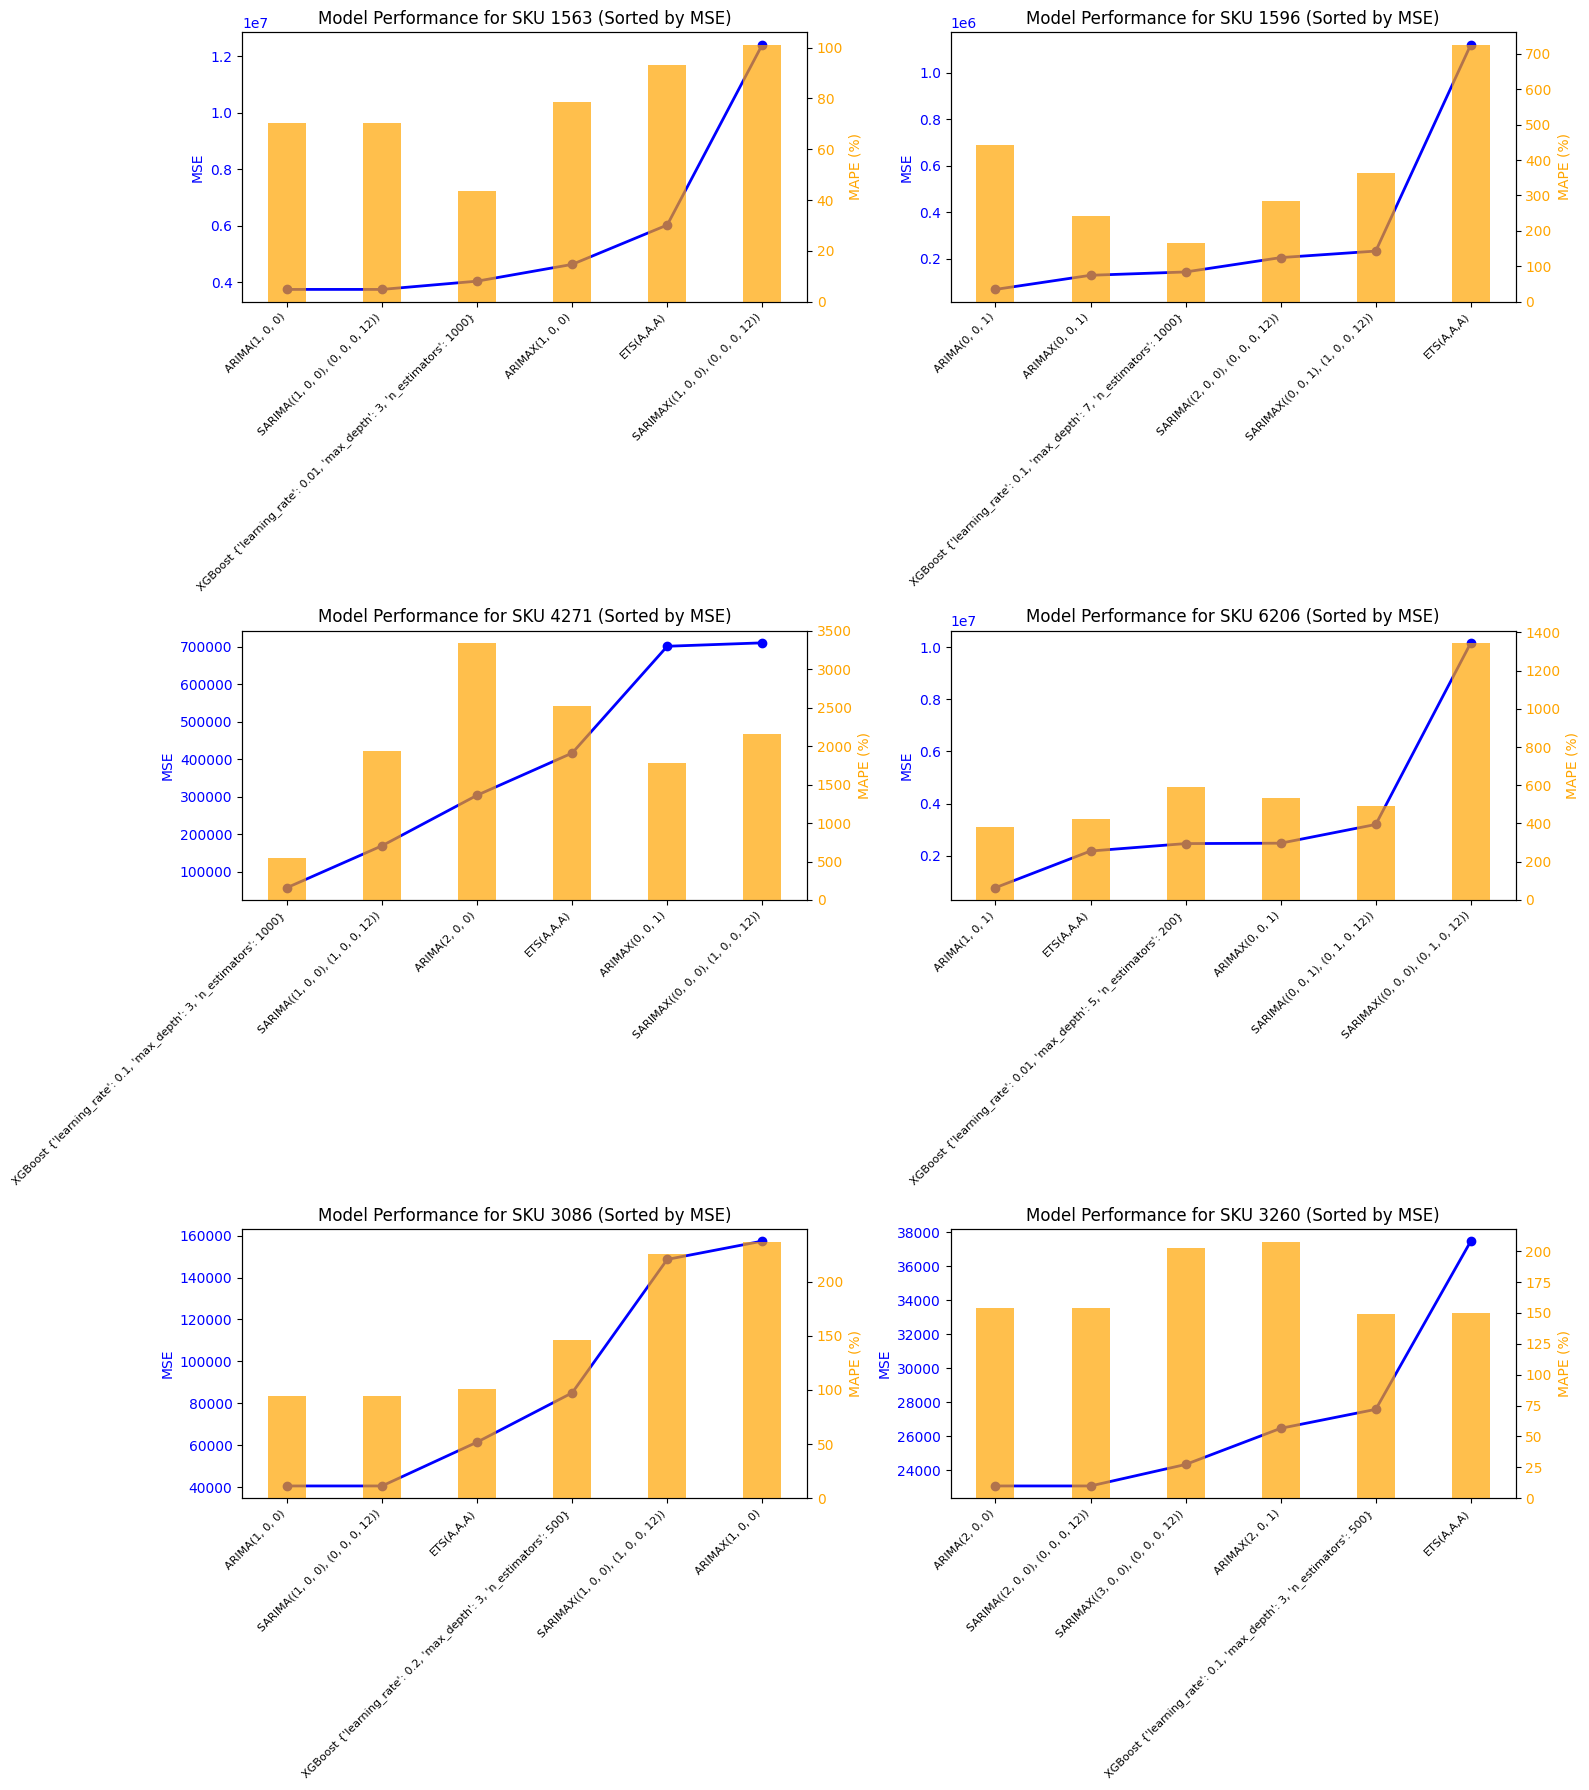

In [30]:
# Plot MSE and MAPE for all models of each medoid SKU, sorted by MSE from lowest to highest
# Arrange plots in 2 columns and 3 rows (one per medoid)
# MSE as line chart, MAPE as column chart

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
medoids = final_results_df['SKU'].unique()

for idx, medoid in enumerate(medoids):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    sku_df = final_results_df[final_results_df['SKU'] == medoid].sort_values('MSE')
    models = sku_df['Model']
    mse = sku_df['MSE']
    mape = sku_df['MAPE']

    x = range(len(models))
    # MSE as line
    ax.plot(x, mse, label='MSE', marker='o', color='blue', linewidth=2)
    ax.set_ylabel('MSE', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # MAPE as bars on twin axis
    ax2 = ax.twinx()
    ax2.bar(x, mape, label='MAPE', alpha=0.7, color='orange', width=0.4)
    ax2.set_ylabel('MAPE (%)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax.set_title(f'Model Performance for SKU {medoid} (Sorted by MSE)')

plt.tight_layout()
plt.show()